#Apple Disease detection using Deep Convolutional Networks

##Contents of this colab file:
1.   Model Training
2.   Model Performance evaluation using intermediate activation maps and heatmaps

## Model Training



Download and unzip dataset which has been augmented with horizontal,vertical flips and brightness variations

In [ ]:
!curl -L https://app.roboflow.ai/ds/3fZYcO8lo1?key=qyRmcj1Q3Q > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [30]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import glob
import os

###Function Definitions

In [15]:
def buildModel(shape,nontrainable=0) :
  model_1 = tf.keras.applications.DenseNet201(input_shape=(shape,shape,3),include_top=False)
  if nontrainable:
    for i in range(nontrainable) :
      model_1.layers[i].trainable = False
  final_layer = tf.keras.layers.GlobalAveragePooling2D()(model_1.output)
  final_layer = tf.keras.layers.Dense(4,activation='softmax')(final_layer)
  model = tf.keras.Model(inputs=model_1.input,outputs=final_layer)
  return model

In [4]:
def predict(path,shape):
  labels = ['healthy','multiple_diseases','rust','scab']
  img = load_img(path,target_size=(shape,shape))
  plt.imshow(img)
  img = img_to_array(img).astype('float')/255
  img = np.expand_dims(img,axis=0)
  return labels[np.argmax(model.predict(img))]

###Build a new model or load a pretrained one

In [16]:
model = buildModel(512,300)
model.load_weights('model_weights.hdf5')

74842112/74836368 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Initialize Data Generators

In [17]:
train_datagen = ImageDataGenerator(rescale= 1./255)
train_generator = train_datagen.flow_from_directory(r"train/",target_size=(512,512),batch_size=16,seed=42)
valid_generator = train_datagen.flow_from_directory(r"valid/",target_size=(512,512),batch_size=64,seed=42)

Found 3079 images belonging to 4 classes.
Found 273 images belonging to 4 classes.


Determine model parameters and calbacks

In [18]:
#declare number of steps
step_size_train = train_generator.n//train_generator.batch_size
step_size_valid = valid_generator.n//valid_generator.batch_size

In [19]:
#determine model parameters
save_path = ''
callback1 = ReduceLROnPlateau(monitor='val_loss',patience=2,min_delta=0.01, factor=0.75)
callback2 = ModelCheckpoint(save_path,save_best_only=True)
optimizer = tf.keras.optimizers.Adam(clipnorm=1.,learning_rate=0.0001)
callbacks = [callback1,callback2]

Compile and Train Model

In [20]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,steps_per_epoch=step_size_train,validation_data=valid_generator,validation_steps=step_size_valid,epochs=30, callbacks=callbacks)

In [21]:
model.evaluate(valid_generator)

5/5 [==============================] - 4s 882ms/step - loss: 0.2721 - accuracy: 0.9560


[0.27214208245277405, 0.9560439586639404]

##Model performance Evaluation

### Intermediate output maps

In [22]:
layer_model = tf.keras.Model(model.input,model.get_layer(index=3).output)

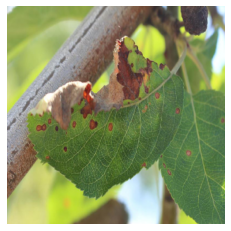

In [23]:
path = glob.glob('valid/multiple_diseases/*.jpg')[9]
img = load_img(path,target_size=(512,512))
img = img_to_array(img).astype('float')/255
plt.axis('off')
plt.imshow(img)

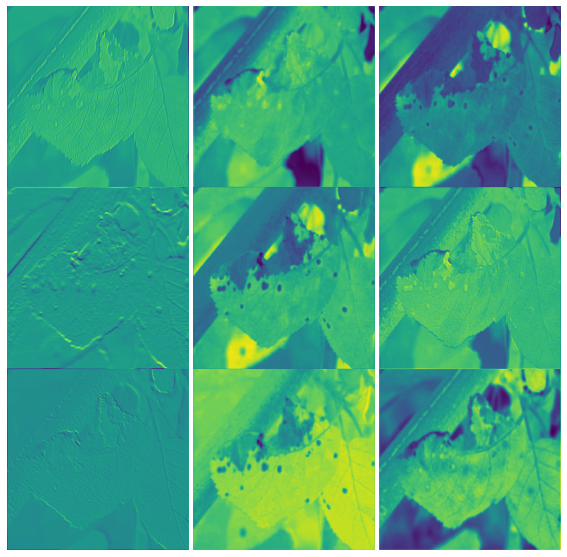

In [24]:
output = layer_model(np.expand_dims(img,axis=0))[0,:,:,:]
num_filters = output.shape[-1]
fig_size = plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0, hspace=0)
best_filters = [4,10,12,14,16,23,30,33,40]
for i in range(len(best_filters)) :
  a = plt.subplot(3,3,i+1)
  plt.imshow(output[:,:,best_filters[i]],)
  plt.axis('off')

### Generate Heatmaps

In [31]:
def show_heatmap(path):
  ORIGINAL = path
  DIM = 512
  img = image.load_img(ORIGINAL, target_size=(DIM, DIM))
  # cv2_imshow(cv2.imread(ORIGINAL))

  x = preprocess_input(np.expand_dims(img, axis=0))

  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('conv5_block32_2_conv')
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape((16, 16))
  # plt.matshow(heatmap)
  # plt.show()
  img = cv2.imread(ORIGINAL)
  INTENSITY = 0.5
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
  img = heatmap * INTENSITY + img
  # cv2_imshow(img)
  return cv2.imread(ORIGINAL),img

In [32]:
path = glob.glob('train/rust/*.jpg')[23]

In [33]:
original,heatmap = show_heatmap(path)

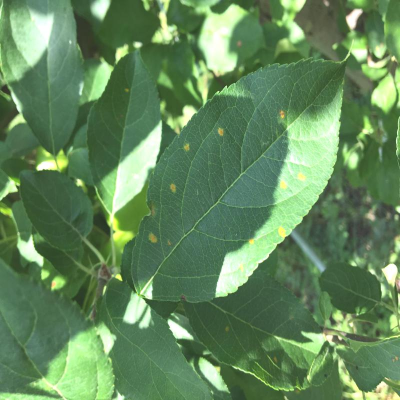

In [39]:
cv2_imshow(cv2.resize(original, (0, 0), fx = 0.5, fy = 0.5))

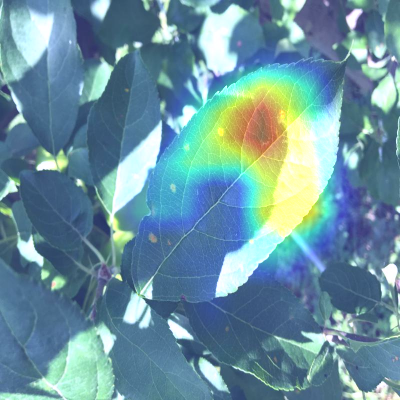

In [40]:
cv2_imshow(cv2.resize(heatmap, (0, 0), fx = 0.5, fy = 0.5))